In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from statsmodels.stats.multitest import fdrcorrection

from sklearn import preprocessing
from sklearn import metrics
import networkx as nx
import mantel

import utils

import pickle

# 1 6 region

In [4]:
def calc_strength_fraction(adj, region_group):
    W = 0
    for set_S in region_group:
        W += adj[set_S, :][:, set_S].sum()
    return W/(adj.sum()-W)

def calc_conductance(nx_adj, region_group):
    cond = 0
    for set_S in region_group:
        cond += nx.algorithms.conductance(nx_adj, set_S, weight="weight")
    return -cond

def calc_normalized_cut(nx_adj, region_group):
    ncut = 0
    for set_S in region_group:
        ncut += nx.algorithms.normalized_cut_size(nx_adj, set_S, weight="weight")
    return -ncut

def significant_test_for_index(corr_mtx, region_group, n_perm=1000):
    # 0. data preparation
    corr_array = np.array(corr_mtx)
    np.fill_diagonal(corr_array, 0)
    corr_array_nx = nx.from_numpy_array(corr_array).to_undirected()

    # 1. calc index
    seg_index = np.array([calc_strength_fraction(corr_array, region_group), 
                          calc_conductance(corr_array_nx, region_group), 
                          calc_normalized_cut(corr_array_nx, region_group)])

    # 2. permutation
    perm_index = np.empty(shape=(n_perm, 3))
    for k in range(n_perm):
        tmp_idx = np.random.permutation(corr_array.shape[0])
        perm_corr = corr_array[tmp_idx, :][:, tmp_idx]
        perm_corr_g = nx.from_numpy_array(perm_corr).to_undirected()

        perm_index[k, 0] = calc_strength_fraction(perm_corr, region_group)
        perm_index[k, 1] = calc_conductance(perm_corr_g, region_group)
        perm_index[k, 2] = calc_normalized_cut(perm_corr_g, region_group)

    pval = ((perm_index>seg_index).sum(axis=0)+1)/n_perm

    # 3. multiple test correction
    _, fdr_bh = fdrcorrection(pval, alpha=0.05, method="indep", is_sorted=False)

    # 4. results
    seg_index[1:] = -seg_index[1:]
    perm_index[:, 1:] = -perm_index[:, 1:]

    return seg_index, perm_index, pval, fdr_bh

In [5]:
expr = pd.read_csv("../res/0.preprocessing/sample_expr.tsv", sep="\t", index_col=0)
info = pd.read_csv("../res/0.preprocessing/sample_info.tsv", sep="\t", index_col=0)

In [17]:
#expr_scale = pd.DataFrame(preprocessing.scale(expr.T, axis=0)).T
expr_scale = expr.copy()
corr_pr = expr_scale.corr(method='pearson')
corr_sp = expr_scale.corr(method='spearman')

upper_idx = np.triu(np.ones(shape=corr_pr.shape), 1).astype(bool)
r_pr_sp, p_pr_sp, _ = mantel.test(corr_pr.to_numpy()[upper_idx], corr_sp.to_numpy()[upper_idx], perms=10000, )
r_pr_sp, p_pr_sp

(0.9656681180769021, 0.0001)

In [18]:
region_group = {}
for i, r in enumerate(info["Region"]):
    if not r in region_group:
        region_group[r] = []
    region_group[r].append(i)
region_group = [ region_group[r] for r in region_group ]
region_group

corr_pr[corr_pr<0] = 0
pr_res = significant_test_for_index(corr_pr, region_group, n_perm=1000)
pr_res[-2], pr_res[-1]

(array([0.067, 0.055, 0.052]), array([0.067, 0.067, 0.067]))

In [19]:
corr_sp[corr_sp<0] = 0
sp_res = significant_test_for_index(corr_sp, region_group, n_perm=1000)
sp_res[-2], sp_res[-1]

(array([0.098, 0.09 , 0.082]), array([0.098, 0.098, 0.098]))

In [20]:
pr_dat_boxplot = pd.DataFrame(pr_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
pr_dat_scatter = pd.DataFrame([pr_res[0], pr_res[-1]], index=["Value", "FDR"]).T
pr_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
pr_dat_scatter["y"] = pr_dat_boxplot.groupby(pr_dat_boxplot["Index"]).quantile(0.99).loc[pr_dat_scatter["Index"]].values + 0.01
pr_dat_scatter

,Value,FDR,Index,y
0,0.219267,0.067,Strength fraction,0.231628
1,5.079171,0.067,Conductance,5.114251
2,6.094682,0.067,Normalized cut,6.135353


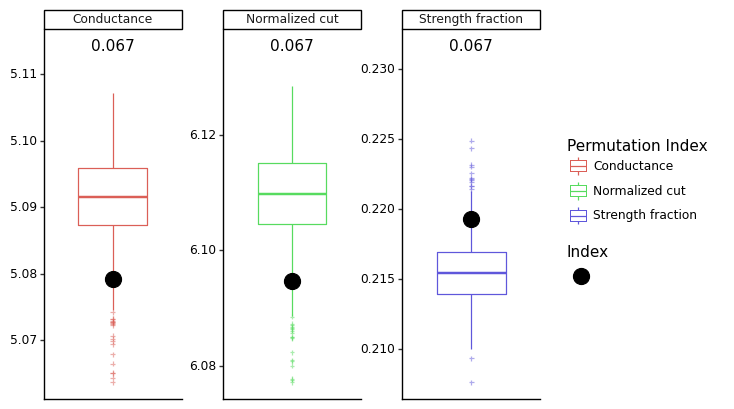

<ggplot: (8792249065807)>

In [21]:
pr_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), pr_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape='+', outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=pr_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), pr_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(pr_plot, "../res/2.pr_plot.pdf", units="in", width=6, height=4, verbose=False )
pr_plot

In [22]:
sp_dat_boxplot = pd.DataFrame(sp_res[1], columns=["Strength fraction", "Conductance", "Normalized cut"]).melt(var_name="Index", value_name="Value")
sp_dat_scatter = pd.DataFrame([sp_res[0], sp_res[-1]], index=["Value", "FDR"]).T
sp_dat_scatter["Index"] = ["Strength fraction", "Conductance", "Normalized cut"]
sp_dat_scatter["y"] = sp_dat_boxplot.groupby(sp_dat_boxplot["Index"]).quantile(0.99).loc[sp_dat_scatter["Index"]].values + 0.01
sp_dat_scatter

,Value,FDR,Index,y
0,0.219411,0.098,Strength fraction,0.233804
1,5.077928,0.098,Conductance,5.118138
2,6.093057,0.098,Normalized cut,6.139967


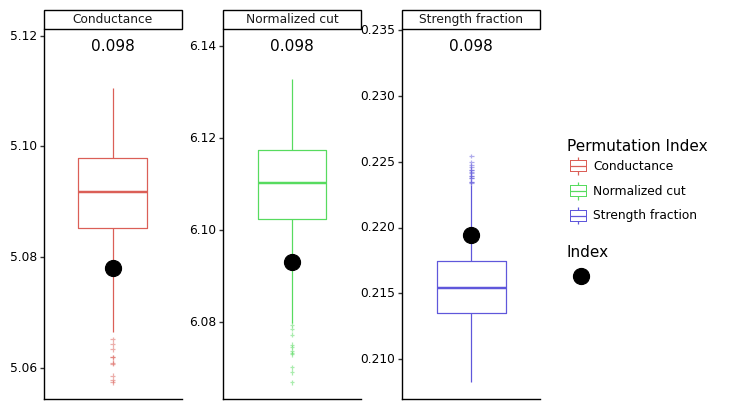

<ggplot: (8792237448427)>

In [23]:
sp_plot = ( p9.ggplot(p9.aes(x="Index", y="Value", color="Index", group="Index"), sp_dat_boxplot) 
  + p9.geom_boxplot(width=0.5, outlier_shape="+", outlier_alpha=0.5)
  + p9.geom_point(p9.aes(x="Index", y="Value", size=5), data=sp_dat_scatter, color="black", )
  + p9.geom_text(p9.aes(x="Index", y="y", label="FDR"), sp_dat_scatter, color="black")
  + p9.facet_wrap("~Index", nrow=1, ncol=3, scales="free")
  + p9.scale_color_discrete(name="Permutation Index")
  + p9.scale_size_continuous(name="Index", breaks=[5], labels=[" "])
  + p9.theme_classic()
  + p9.theme(subplots_adjust={'wspace': 0.30},
             axis_title=p9.element_blank(),
             axis_text_x=p9.element_blank(),
             axis_ticks_major_x=p9.element_blank(),
             axis_text=p9.element_text(color="black")
             
            )
)
p9.ggsave(sp_plot, "../res/2.sp_plot.pdf", units="in", width=6, height=4, verbose=False )
sp_plot